# Lecture 02 Kalman Filter

In [85]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from pandas_datareader import DataReader
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf

In [86]:
def kalman_filter(param,*args):
    # initialize params
    Z = param[0]
    T = param[1]
    H = param[2]
    Q = param[3]
    # initialize vector values:
    u_predict,  u_update,  P_predict, P_update, v, F = {},{},{},{},{},{}
    u_update[0] = Y[0]
    u_predict[0] = u_update[0] 
    P_update[0] = np.var(Y)/4 
    P_predict[0] =  T*P_update[0]*np.transpose(T)+Q  
    Likelihood = 0
    for s in range(1, S):
        F[s] = Z*P_predict[s-1]*np.transpose(Z)+H 
        v[s]= Y[s-1]-Z*u_predict[s-1]   
        u_update[s] = u_predict[s-1]+P_predict[s-1]*np.transpose(Z)*(1/F[s])*v[s]
        u_predict[s] = T*u_update[s]
        P_update[s] = P_predict[s-1]-P_predict[s-1]*np.transpose(Z)*(1/F[s])*Z*P_predict[s-1]
        P_predict[s] = T*P_update[s]*np.transpose(T)+Q
        Likelihood += (1/2)*np.log(2*np.pi)+(1/2)*np.log(abs(F[s]))+(1/2)*np.transpose(v[s])*(1/F[s])*v[s]      
    
    return Likelihood

In [87]:
def kalman_smoother(params, *args):
    # Initialize parameters from the params array
    Z = params[0]           # Latent component: Observation matrix, relating the state to the observation
    T = params[1]           # Transition matrix, relating the current state to the next state
    H = params[2]           # Measurement noise covariance (shock in the observation)
    Q = params[3]           # Process noise covariance (shock to latent component/state)

    # Initialize dictionaries to store the predicted and updated estimates and covariances
    u_predict, u_update, P_predict, P_update, v, F = {}, {}, {}, {}, {}, {}

    # Initial state estimate and covariance
    u_update[0] = Y[0]                      # Initialize state estimate with the first observed value
    u_predict[0] = u_update[0]              # Predict the first state using the initial state estimate
    P_update[0] = np.var(Y) / 4             # Initial state covariance set to 1/4th of variance of the observations
    P_predict[0] = T * P_update[0] * np.transpose(T) + Q  # Predicted state covariance for the next time step

    # Forward pass: Kalman Filter iteration
    for s in range(1, S):
        # Calculate prediction error covariance matrix
        F[s] = Z * P_predict[s-1] * np.transpose(Z) + H  # Variance of the prediction error

        # Prediction error (innovation): difference between observed and predicted state
        v[s] = Y[s-1] - Z * u_predict[s-1]               # Observation residual

        # Update the state with prediction error weighted by Kalman gain
        u_update[s] = u_predict[s-1] + P_predict[s-1] * np.transpose(Z) * (1 / F[s]) * v[s]

        # Predict the next state using the updated state
        u_predict[s] = T * u_update[s]

        # Update the state covariance using Kalman gain
        P_update[s] = P_predict[s-1] - P_predict[s-1] * np.transpose(Z) * (1 / F[s]) * Z * P_predict[s-1]

        # Predict the state covariance for the next time step
        P_predict[s] = T * P_update[s] * np.transpose(T) + Q

    # Backward pass: Kalman Smoothing
    u_smooth, P_smooth = {}, {}

    # Initialize smoothing with the last filtered estimate
    u_smooth[S-1] = u_update[S-1]    # Set the last smoothed state to the last updated state
    P_smooth[S-1] = P_update[S-1]    # Set the last smoothed covariance to the last updated covariance

    # Smooth from last to first observation
    for t in range(S-1, 0, -1):
        # Smooth the state estimates backward in time
        u_smooth[t-1] = u_update[t] + P_update[t] * np.transpose(T) / P_predict[t] * (u_smooth[t] - T * u_update[s])

        # Smooth the covariance estimates backward in time
        P_smooth[t-1] = P_update[t] + P_update[t] * np.transpose(T) / P_predict[t] * (P_smooth[t] - P_predict[t]) / P_predict[t] * T * P_update[t]

    # Return the smoothed path (smoothed state estimates)
    smooth_path = u_smooth
    return smooth_path


[*********************100%***********************]  1 of 1 completed

         Current function value: 590.065891
         Iterations: 3
         Function evaluations: 603
         Gradient evaluations: 119
RMSE values is: $ 17.112925171932957


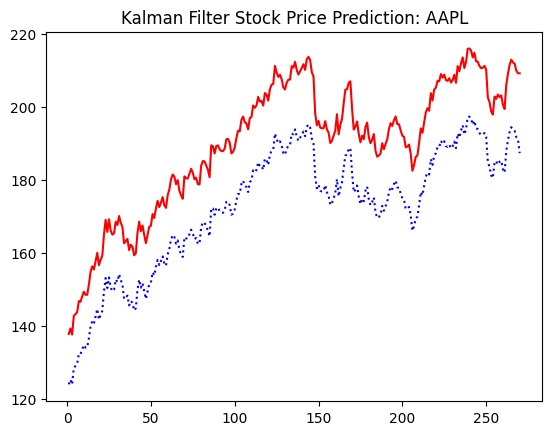

In [88]:
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 1, 31)
stock_symbol = 'AAPL'
stock = yf.download(stock_symbol, start_date, end_date)   # Download stock data for NVDA from Yahoo Finance within the specified date range
Y = stock['Adj Close'].values                             # Extract the Adjusted Close prices into an array Y
S = Y.shape[0]                                            # Get the number of data points in the series

# Initialize Kalman Filter parameters
param0 = np.array([1.05, 0.95, np.var(Y) / 40, np.var(Y) / 75])  # Initial parameter values for the Kalman Filter

# Apply optimization to minimize the error using the Kalman filter function
results = minimize(kalman_filter, param0, method='BFGS', tol=1e-2, options={'disp': True})

# Retrieve optimized parameters from the result
param_star = results.x                                    # Extract optimized parameters
path = kalman_smoother(param_star, Y, S)                  # Generate the smoothed path using the Kalman smoother function
sorted_path = dict(sorted(path.items()))                  # Sort the path dictionary by time index for plotting
Y_kalmanFilter = sorted_path.values()                     # Extract smoothed values in order for visualization

# Create a time vector for plotting
timevec = np.linspace(1, S, S)                            # Generate a linear time vector to match the data points
plt.title('Kalman Filter Stock Price Prediction: ' + stock_symbol)  # Set plot title
plt.plot(timevec, Y_kalmanFilter, 'r', timevec, Y, 'b:')  # Plot the smoothed path in red and original data in blue

# Convert smoothed values to a list for further calculations
kalman_values = list(Y_kalmanFilter)                      # Store the smoothed path values in a list

# Calculate RMSE (Root Mean Squared Error) to assess prediction accuracy
RMSE = np.sqrt(np.mean((np.array(kalman_values) - np.array(Y)) ** 2))  # Calculate RMSE
print('RMSE values is: $', RMSE)                          # Print the RMSE for the Kalman Filter predictions
